# SIMULATION OF NLOS-VLC SYSTEM USING THE ROLLING SHUTTER MECHANISM

### Import the transmitter, surface and camera objects, as well as numpy library.

In [1]:
from constants import Constants as Kt
#Import module Transmitter
from transmitter import Transmitter as Transmitter

from surface import Surface as Surface

from camera import Camera as Camera

from rollingshutter import RollingShutter as RS

import numpy as np


### The trasmitter is defined as a Trasmitter type object from nine input parameters


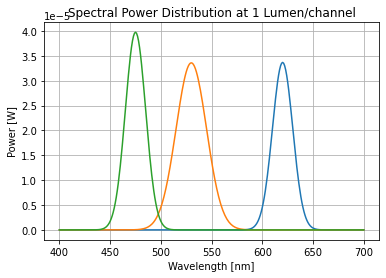


 List of parameters for LED transmitter: 
Name: Led1
Position [x y z]: [0.0000e+00 5.8579e-01 5.8579e-01] 
Normal Vector [x y z]: [0.0000e+00 1.0000e+00 -1.0000e+00] 
Lambert Number: 1.0 
Central Wavelengths [nm]: [6.2000e+02 5.3000e+02 4.7500e+02] 
FWHM [nm]: [2.0000e+01 3.0000e+01 2.0000e+01]
Luminous Flux [lm]: 1000.0
ILER [W/lm]: 
 [[3.8001e-03 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.8197e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.1960e-02]] 
Average Power per Channel Color: 
 [8.4447e-01 1.2636e+00 9.9670e-01] 
Total Power emmited by the Transmitter [W]: 
 3.1048221352160126 
Color Temperature: 
 [[6.7435e+03]]


In [2]:
transmitter = Transmitter(
        "Led1",
        position=[0, 2-(2**0.5), 2-(2**0.5)],
        normal=[0, 1, -1],
        mlambert=1,
        wavelengths=[620, 530, 475],
        fwhm=[20, 30, 20],
        modulation='white-16',
        frequency=2000,
        no_symbols=1000,
        luminous_flux=1000
    )
# transmitter.plot_spd_normalized()
transmitter.plot_spd_at_1lm()
# transmitter.plot_led_pattern()
print(transmitter)

### The surface is defined from eight imputs parametes

In [3]:
surface = Surface(
    name="surfacePlaster",
    position=[0, 2, 0],
    reflectance='plaster',
    vertex1=[-1/10, 0, -1/10],
    vertex2=[1/10, 0, -1/10],
    vertex3=[1/10, 0, 1/10],
    vertex4=[-1/10, 0, 1/10]
    )
# surface.plot_reflectance()
surface._group_vertices()
print(surface)


 List of parameters for LED transmitter: 
Name: surfacePlaster
Position [x y z]: [0.0000e+00 2.0000e+00 0.0000e+00] 
Normal Vector [x y z]: [0.0000e+00 -1.0000e+00 0.0000e+00] 
Reflectance Material: plaster 
Area: 0.04000000283122063 



### The camera is defined from a set of 13 input parameters

In [ ]:
PIXEL_SIZE = 1.12e-6
MX = 1/PIXEL_SIZE  # number of pixels per unit distance in image coordinates in x direction
MY = 1/PIXEL_SIZE  # number of pixels per unit distance in image coordinates in y direction
FOCAL_LENGTH = 3e-3  # focal length
THETA_X = np.pi / 2.0  # roll angle
THETA_Y = np.pi  # pitch angle
THETA_Z = np.pi  # yaw angle
C = np.array([0, 3/2, 0])  # camera centre
IMAGE_WIDTH = 1640/4
IMAGE_HEIGTH = 1232/4
PX= IMAGE_WIDTH/(2*MX)  # principal point x-coordinate
PY= IMAGE_HEIGTH/(2*MY)  # principal point y-coordinate

camera = Camera(
    name="camera1",
    focal_length=FOCAL_LENGTH,
    pixel_size=1/MX,
    px=PX,
    py=PY,
    mx=MX,
    my=MY,
    theta_x=THETA_X,
    theta_y=THETA_Y,
    theta_z=THETA_Z,
    centre=C,
    image_height=IMAGE_HEIGTH,
    image_width=IMAGE_WIDTH,    
    surface=surface,
    transmitter=transmitter,
    sensor='SonyStarvisBSI'
    )
camera.take_picture()
camera.plot_responsivity()
camera.plot_image_intensity()



In [ ]:
import numpy as np
import cv2
# Library to plot 
import matplotlib as plt

# Create a float grayscale array (values between 0.0 and 1.0)
gray_array = camera._power_image / np.max(camera._power_image)


# Scale the float values to the range 0-255 (8-bit)
gray_array_scaled = (gray_array * 255).astype(np.uint8)

plt.image.imsave('ConfigB-50cm.png', gray_array_scaled, cmap='gray')

# Save the image as a PNG file
# cv2.imwrite('output.png', gray_array_scaled)


### The Rolling Shutter module is added.

In [ ]:
# Library to plot 
import matplotlib.pyplot as plt

rollingshutter = RS(
    name="rs",
    t_exposure=85e-6,
    t_rowdelay=18.904e-6,
    t_start=0,
    iso=200,
    adc_resolution=8,
    gain_pixel=14.9e26,
    temperature=298,
    idark=1e-14,
    transmitter=transmitter,
    camera=camera
)

rollingshutter.plot_color_image()
rollingshutter.add_blur(size=7, center=3.5, sigma=0.5)
rollingshutter.plot_blurred_image()





### Compute the minimum distance

In [ ]:
# Library to plot 
# import matplotlib as plt
import matplotlib.pyplot as plt
# %matplotlib qt


# plt.image.imsave('ConfigB-Color-50cm.png', rollingshutter._rgb_image)

def cdist(XA, XB) -> np.ndarray:
    # Calculate the Euclidean distance between each pair of points in XA and XB
    D = np.sqrt(((XA[:, None] - XB) ** 2).sum(axis=2))

    return D

rgb_image = rollingshutter._rgb_image
row_indexes = rollingshutter._index_row_bins

symbolR = 20 

symbolG = 21
symbolB = 22

column_down = 400
column_up = 1200

symbol_start = 20
symbol_stop = 38

rowR = rollingshutter._index_row_bins[symbolR]
rowG = rollingshutter._index_row_bins[symbolG]
rowB = rollingshutter._index_row_bins[symbolB]

rx_symbols =  np.zeros((Kt.NO_LEDS, int(symbol_stop-symbol_start+1)))
i=0

for row_counter in range(symbol_start, symbol_stop+1):    
    rx_symbols[0, i] = np.average(
        rgb_image[
            row_indexes[row_counter-1]+1:row_indexes[row_counter]+1,
            column_down:column_up,
            0]
        )
    rx_symbols[1, i] = np.average(
        rgb_image[
            row_indexes[row_counter-1]+1:row_indexes[row_counter]+1,
            column_down:column_up,
            1]
        )
    rx_symbols[2, i] = np.average(
        rgb_image[
            row_indexes[row_counter-1]:row_indexes[row_counter],
            column_down:column_up,
            2]
        )
    i = i + 1

print("Interchannel interference matrix:")
H = rx_symbols[:, 0:3]
print(H)

print("Inverse Interchannel interference matrix:")
H_inv = np.linalg.inv(H)
print(H_inv)

print("Decoded symbols:")
decoded_symbols = np.matmul(H_inv, rx_symbols)
print(decoded_symbols)


zero_distance = cdist(rx_symbols[:, 3:19].T, rx_symbols[:, 3:19].T)
                

min_distance = np.min(zero_distance[zero_distance > 0])
print("Minimum distance:")
print(min_distance)


plt.imshow(rgb_image[
            row_indexes[19]+1:row_indexes[20]+1,
            column_down:column_up,
            :])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
ax.scatter(
        rx_symbols[0, 3:19],
        rx_symbols[1, 3:19],
        rx_symbols[2, 3:19]
    )
 # Set limits for the axes
ax.set_xlim3d([0, 255])
ax.set_ylim3d([0, 255])
ax.set_zlim3d([0, 255])
# Add labels and title
ax.set_xlabel('R-axis')
ax.set_ylabel('G-axis')
ax.set_zlabel('B-axis')
plt.title('Constellation in RAW Signal Space')

# Display plot
plt.show()
# print(avg_color)

In [ ]:
T = np.zeros((3,3))
T[0,:] = [2/3, 0, 0]
T[1,:] = [1/3, 1, 3/4]
T[2,:] = [0, 0, 1/4]

print(T)
print(np.shape(Kt.IEEE_16CSK))
result = np.matmul(T, Kt.IEEE_16CSK)
print(repr(result))
print(result)

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
%matplotlib qt

constellation = Kt.WARM_16CSK

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Draw a triangle of the received constellation
p1 = constellation[:, np.argmax(constellation[0, :])]
p2 = constellation[:, np.argmax(constellation[1, :])]
p3 = constellation[:, np.argmax(constellation[2, :])]

ax.scatter([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], [p1[2], p2[2], p3[2]])
# Define the vertices for the polygon
verts = [p1, p2, p3]
# Create the polygon
poly = Poly3DCollection([verts], alpha=0.25, facecolor='g')
# Add the polygon to the plot
ax.add_collection3d(poly)


ax.scatter(
        constellation[0, :],
        constellation[1, :],
        constellation[2, :],
        s=30,
        c='blue'
    )

 # Set font size for axis labels and title
plt.rcParams['font.size'] = 16

# Define the coordinates for the plane
xx, yy = np.meshgrid(range(1), range(1))
zz = 2 * xx + 3 * yy

# Plot the plane
ax.plot_surface(xx, yy, zz, alpha=0.5)
ax.view_init(30, 45)

 # Set limits for the axes
ax.set_xlim3d([0, 1])
ax.set_ylim3d([0, 1])
ax.set_zlim3d([0, 1])
# Add labels and title
ax.set_xlabel('R-axis')
ax.set_ylabel('G-axis')
ax.set_zlabel('B-axis')
# plt.title('Constellation in RAW Signal Space')

# Display plot
plt.show()
# plt.savefig('foo.png')
